In [1]:
import pandas as pd 
import numpy as np 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'seaborn'

# Load the dataset

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'Final_student_performance.csv'
student_data = pd.read_csv(file_path)

In [284]:
student_data.head()

,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Parent Education Level,Gender,Engagement Level,Contact Info,Library Card Number,Grade Level,Age,Country
0,S00001,12.5,NaN,75.0,Master,Male,1.0,696-714-1914,LC5826,Grade 11,16,Germany
1,S00002,9.3,95.3,60.6,High School,Female,1.0,917-757-1895,LC2486,Grade 10,15,Germany
2,S00003,13.2,NaN,64.0,Associate,Male,1.0,153-414-5117,LC4867,Grade 12,17,Germany
3,S00004,17.6,76.8,62.4,Bachelor,Male,0.0,902-419-9995,LC7944,Grade 11,16,France
4,S00005,8.8,89.3,72.7,Master,Male,1.0,967-163-8176,NaN,Grade 11,16,England


In [285]:
student_data.describe()

,Study Hours per Week,Attendance Rate,Previous Grades,Engagement Level,Age
count,38005.000000,38008.000000,38006.000000,38795.000000,40000.000000
mean,9.962744,75.276323,65.440107,1.874236,16.052850
std,5.031154,20.393418,16.503119,1.567700,0.802884
min,-12.300000,-14.300000,8.300000,0.000000,14.000000
25%,6.600000,61.600000,55.100000,1.000000,15.000000
50%,10.000000,75.300000,65.200000,1.000000,16.000000
75%,13.400000,88.800000,75.200000,3.000000,17.000000
max,32.400000,150.200000,200.000000,5.000000,18.000000


In [286]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Student ID              40000 non-null  object 
 1   Study Hours per Week    38005 non-null  float64
 2   Attendance Rate         38008 non-null  float64
 3   Previous Grades         38006 non-null  float64
 4   Parent Education Level  38000 non-null  object 
 5   Gender                  40000 non-null  object 
 6   Engagement Level        38795 non-null  float64
 7   Contact Info            40000 non-null  object 
 8   Library Card Number     29929 non-null  object 
 9   Grade Level             40000 non-null  object 
 10  Age                     40000 non-null  int64  
 11  Country                 40000 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 3.7+ MB


In [287]:
def print_missing_values(student_data):
    missing_values = student_data.isnull().sum()
    print(missing_values)
print_missing_values(student_data)

Student ID                    0
Study Hours per Week       1995
Attendance Rate            1992
Previous Grades            1994
Parent Education Level     2000
Gender                        0
Engagement Level           1205
Contact Info                  0
Library Card Number       10071
Grade Level                   0
Age                           0
Country                       0
dtype: int64


In [288]:
duplicate_rows = student_data.duplicated().sum()
print(f'No. of Duplicate rows: {duplicate_rows}')

No. of Duplicate rows: 0


In [289]:
unique_values = student_data.nunique()
print(unique_values)

Student ID                40000
Study Hours per Week        355
Attendance Rate            1235
Previous Grades             956
Parent Education Level        5
Gender                        2
Engagement Level              6
Contact Info              40000
Library Card Number        8691
Grade Level                   3
Age                           5
Country                       5
dtype: int64


# Step 1: Data Cleaning

In [290]:
# Fill missing numeric values with the median
numeric_columns = ['Study Hours per Week', 'Attendance Rate', 'Previous Grades', 'Engagement Level']
student_data[numeric_columns] = student_data[numeric_columns].fillna(student_data[numeric_columns].median())

In [291]:
# Fill missing categorical values with the mode
categorical_columns = [
    'Parent Education Level',
    'Library Card Number'
]
for column in categorical_columns:
    student_data[column] = student_data[column].fillna(student_data[column].mode()[0])

In [292]:
# Detect and handle outliers using the Interquartile Range (IQR) method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

for column in numeric_columns:
    handle_outliers(student_data, column)

In [293]:
# Convert categorical columns to category data type
student_data[categorical_columns] = student_data[categorical_columns].astype('category')

In [294]:
# Drop unnecessary columns
columns_to_drop = ["Contact Info","Library Card Number"]
student_data = student_data.drop(columns=columns_to_drop, errors='ignore')

# Step 2: Feature Engineering

In [295]:
# Calculate an academic performance score (weighted metric of grades, attendance, and study hours)
student_data['Performance Score'] = (
    student_data['Previous Grades'] * 0.5 +  # Grades weigh 50%
    student_data['Attendance Rate'] * 0.3 +  # Attendance weighs 30%
    student_data['Study Hours per Week'] * 0.2  # Study hours weigh 20%
)

In [296]:
# Categorize engagement levels
engagement_labels = ['Low', 'Moderate', 'High']
student_data['Engagement Category'] = pd.cut(
    student_data['Engagement Level'],
    bins=[-1, 2, 4, 6],
    labels=engagement_labels
)

In [297]:
engagement_counts = student_data['Gender'].value_counts()
engagement_counts

Gender
Male      26517
Female    13483
Name: count, dtype: int64

In [298]:
# Calculate attendance group
student_data['Attendance Group'] = pd.cut(
    student_data['Attendance Rate'],
    bins=[0, 50, 75, 127],
    labels=['Low', 'Moderate', 'High']
)

In [299]:
max_value = student_data['Attendance Rate'].max()
max_value

126.15000000000002

In [300]:
print_missing_values(student_data)

Student ID                0
Study Hours per Week      0
Attendance Rate           0
Previous Grades           0
Parent Education Level    0
Gender                    0
Engagement Level          0
Grade Level               0
Age                       0
Country                   0
Performance Score         0
Engagement Category       0
Attendance Group          0
dtype: int64


In [301]:
# Identify students at risk based on performance score threshold
student_data['At Risk'] = student_data['Performance Score'] < 50

In [302]:
student_data.head(20)

,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Parent Education Level,Gender,Engagement Level,Grade Level,Age,Country,Performance Score,Engagement Category,Attendance Group,At Risk
0,S00001,12.5,75.3,75.0,Master,Male,1.0,Grade 11,16,Germany,62.59,Low,High,False
1,S00002,9.3,95.3,60.6,High School,Female,1.0,Grade 10,15,Germany,60.75,Low,High,False
2,S00003,13.2,75.3,64.0,Associate,Male,1.0,Grade 12,17,Germany,57.23,Low,High,False
3,S00004,17.6,76.8,62.4,Bachelor,Male,0.0,Grade 11,16,France,57.76,Low,High,False
4,S00005,8.8,89.3,72.7,Master,Male,1.0,Grade 11,16,England,64.90,Low,High,False
5,S00006,8.8,73.8,69.3,High School,Male,0.0,Grade 11,16,England,58.55,Low,Moderate,False
6,S00007,17.9,38.6,93.6,Doctorate,Male,1.0,Grade 11,16,France,61.96,Low,Low,False
7,S00008,13.8,95.8,59.2,Doctorate,Female,1.0,Grade 11,16,Germany,61.10,Low,High,False
8,S00009,7.7,100.1,91.9,Bachelor,Female,5.0,Grade 11,16,Germany,77.52,High,High,False
9,S00010,12.7,38.4,37.8,High School,Male,0.0,Grade 12,17,England,32.96,Low,Low,True


# Step 3: Data Normalization and Encoding

In [303]:
# Define numerical and categorical columns for preprocessing
numerical_features = ['Study Hours per Week', 'Attendance Rate', 'Previous Grades', 'Engagement Level', 'Performance Score']
categorical_features = ['Parent Education Level', 'Engagement Category', 'Attendance Group']

# Normalize numerical features using MinMaxScaler
scaler = MinMaxScaler()

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=True)

# Fit the encoder on the categorical features
encoder.fit(student_data[categorical_features])

# Combine preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', encoder, categorical_features)
    ]
)

# Apply preprocessing
processed_data = preprocessor.fit_transform(student_data)

# Get encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
processed_columns = numerical_features + list(encoded_feature_names)

# Convert processed data back to a DataFrame
student_data_normalized = pd.DataFrame(processed_data, columns=processed_columns)

In [304]:
student_data_normalized

,Study Hours per Week,Attendance Rate,Previous Grades,Engagement Level,Performance Score,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master,Engagement Category_Low,Engagement Category_Moderate,Attendance Group_Low,Attendance Group_Moderate
0,0.597656,0.501471,0.630291,0.2,0.575466,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.472656,0.697549,0.439815,0.2,0.549067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.625000,0.501471,0.484788,0.2,0.498565,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.796875,0.516176,0.463624,0.0,0.506169,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.453125,0.638725,0.599868,0.2,0.608608,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.718750,0.682843,0.318122,0.0,0.494692,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
39996,0.550781,0.414216,0.487434,0.8,0.456241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
39997,0.621094,0.406373,0.142196,0.8,0.270732,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
39998,0.660156,0.497549,0.500661,0.4,0.508034,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [305]:
student_data

,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Parent Education Level,Gender,Engagement Level,Grade Level,Age,Country,Performance Score,Engagement Category,Attendance Group,At Risk
0,S00001,12.5,75.3,75.0,Master,Male,1.0,Grade 11,16,Germany,62.59,Low,High,False
1,S00002,9.3,95.3,60.6,High School,Female,1.0,Grade 10,15,Germany,60.75,Low,High,False
2,S00003,13.2,75.3,64.0,Associate,Male,1.0,Grade 12,17,Germany,57.23,Low,High,False
3,S00004,17.6,76.8,62.4,Bachelor,Male,0.0,Grade 11,16,France,57.76,Low,High,False
4,S00005,8.8,89.3,72.7,Master,Male,1.0,Grade 11,16,England,64.90,Low,High,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,S39996,15.6,93.8,51.4,Master,Female,0.0,Grade 10,15,Germany,56.96,Low,High,False
39996,S39997,11.3,66.4,64.2,Doctorate,Female,4.0,Grade 10,15,Portugal,54.28,Moderate,Moderate,False
39997,S39998,13.1,65.6,38.1,Bachelor,Male,4.0,Grade 11,16,England,41.35,Moderate,Moderate,True
39998,S39999,14.1,74.9,65.2,Master,Male,2.0,Grade 11,16,Germany,57.89,Low,Moderate,False


# Step 3: Visualizations

C:\Users\fares\AppData\Local\Temp\ipykernel_22132\2074556463.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=student_data, x='Engagement Category', palette='viridis')
C:\Users\fares\AppData\Local\Temp\ipykernel_22132\2074556463.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=student_data, x='Attendance Group', palette='pastel')
C:\Users\fares\AppData\Local\Temp\ipykernel_22132\2074556463.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=student_data, x='At Risk', palette='coolwarm')


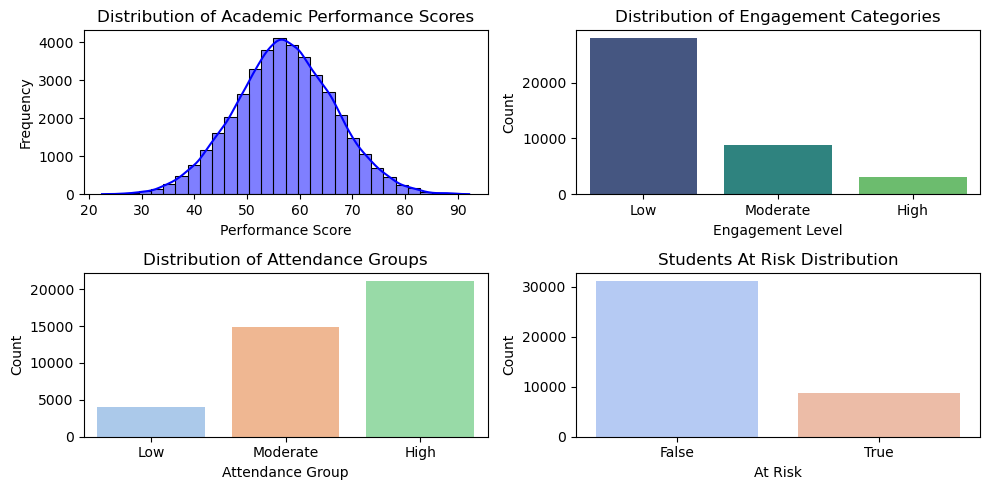

In [306]:
# Academic Performance Distribution
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
sns.histplot(student_data['Performance Score'], kde=True, bins=30, color='blue')
plt.title('Distribution of Academic Performance Scores')
plt.xlabel('Performance Score')
plt.ylabel('Frequency')

# Engagement Level Distribution
plt.subplot(2, 2, 2)
sns.countplot(data=student_data, x='Engagement Category', palette='viridis')
plt.title('Distribution of Engagement Categories')
plt.xlabel('Engagement Level')
plt.ylabel('Count')

# Attendance Group Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=student_data, x='Attendance Group', palette='pastel')
plt.title('Distribution of Attendance Groups')
plt.xlabel('Attendance Group')
plt.ylabel('Count')

# At Risk Students Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=student_data, x='At Risk', palette='coolwarm')
plt.title('Students At Risk Distribution')
plt.xlabel('At Risk')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

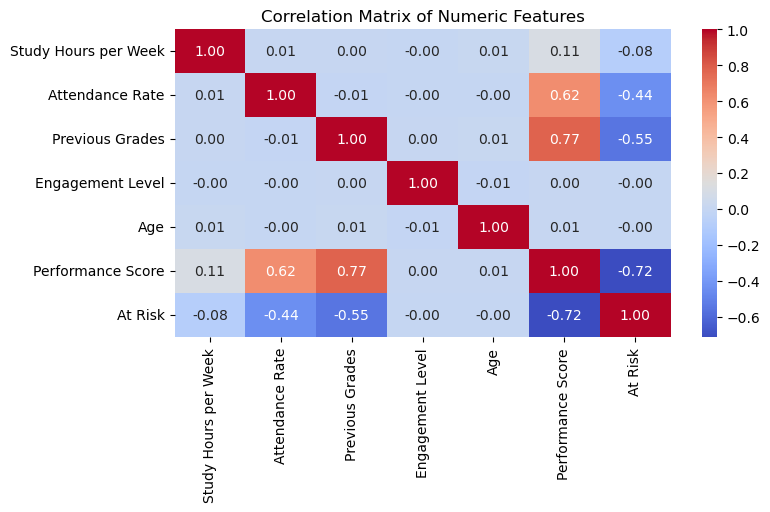

In [307]:
# Correlation Heatmap
correlation_matrix = student_data.corr(numeric_only=True)
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

C:\Users\fares\AppData\Local\Temp\ipykernel_22132\2376304727.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_performance = student_data['Performance Score'].groupby(student_data['Engagement Category']).sum().sort_values()


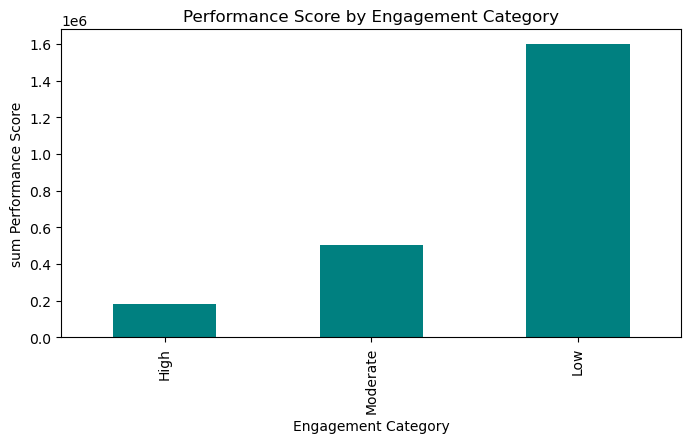

C:\Users\fares\AppData\Local\Temp\ipykernel_22132\2376304727.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_study_hours = student_data['Study Hours per Week'].groupby(student_data['Attendance Group']).sum().sort_values()


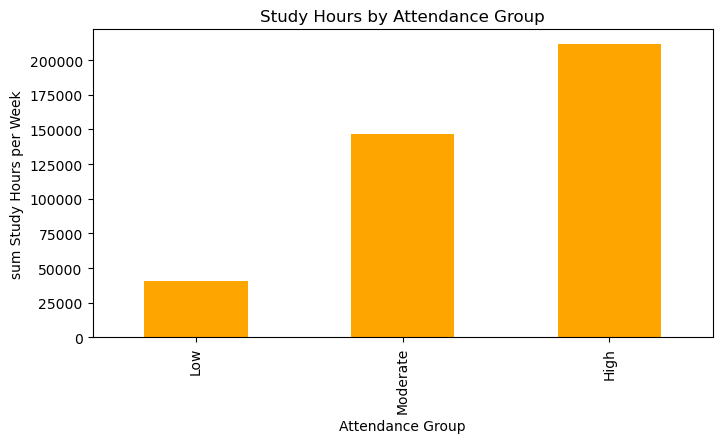

In [308]:
# Step 4: Further Analysis

# Average performance score by engagement category
engagement_performance = student_data['Performance Score'].groupby(student_data['Engagement Category']).sum().sort_values()
plt.figure(figsize=(8, 4))
engagement_performance.plot(kind='bar', color='teal')
plt.title('Performance Score by Engagement Category')
plt.xlabel('Engagement Category')
plt.ylabel('sum Performance Score')
plt.show()

# Average study hours by attendance group
attendance_study_hours = student_data['Study Hours per Week'].groupby(student_data['Attendance Group']).sum().sort_values()
plt.figure(figsize=(8, 4))
attendance_study_hours.plot(kind='bar', color='orange')
plt.title('Study Hours by Attendance Group')
plt.xlabel('Attendance Group')
plt.ylabel('sum Study Hours per Week')
plt.show()

# Step 5: Save Cleaned Data

In [309]:
# Save the cleaned and processed dataset for further use
student_data.to_csv('cleaned_student_data.csv', index=False)
